# Face Mask Detection Project using PyTorch

# TODO
1.   Download the dataset
2.   Import the dataset using PyTorch
3.   Explore the dataset
4.   Prepare the dataset for training



In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

# Download the dataset
I found this dataset on [Kaggle](https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset) and  I am using `opendatasets` library to download this dataset. 

In [4]:
!pip install opendatasets --upgrade --quiet

In [5]:
import opendatasets as od

In [6]:
dataset_url = 'https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset'
od.download(dataset_url)

  5%|▍         | 16.0M/330M [00:00<00:02, 165MB/s]

100%|██████████| 330M/330M [00:01<00:00, 291MB/s]


In [7]:
data_dir = '/content/face-mask-12k-images-dataset/Face_Mask_Dataset'

In [8]:
import os

In [9]:
list(os.listdir(data_dir))

['Test', 'Validation', 'Train']

# Importing the dataset into PyTorch
Use `ImageFolder` class from `torchvision`

In [10]:
from torchvision.datasets import ImageFolder

In [11]:
train_dir = data_dir + '/Train'
test_dir = data_dir + '/Test'
val_dir = data_dir + '/Validation'

In [12]:
import torchvision.transforms as tt

transform = tt.Compose([tt.Resize(100),tt.RandomCrop(100),tt.ToTensor()])

In [13]:
train_ds = ImageFolder(root=train_dir, transform=transform)
val_ds = ImageFolder(root=val_dir, transform= transform)
test_ds = ImageFolder(root=test_dir, transform=transform )

In [14]:
im_count = 0
for image,_ in train_ds:
  im_count += 1
  print(image.shape)
  if im_count == 10:
    break 

torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])


In [15]:
%matplotlib inline

In [16]:
def show_example(img,label):
  print('Label: ', train_ds.classes[label], '('+str(label)+')')
  plt.imshow(img.permute(1, 2, 0))

Label:  WithoutMask (1)


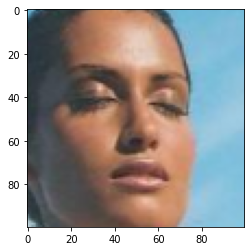

In [17]:
show_example(*train_ds[9830])

Label:  WithMask (0)


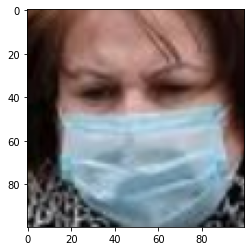

In [18]:
show_example(*train_ds[279])

In [19]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32

In [20]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers= 4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

In [22]:
def show_batch(dl):
  for img, label in dl:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(img, nrow = 8).permute(1,2,0))
    break

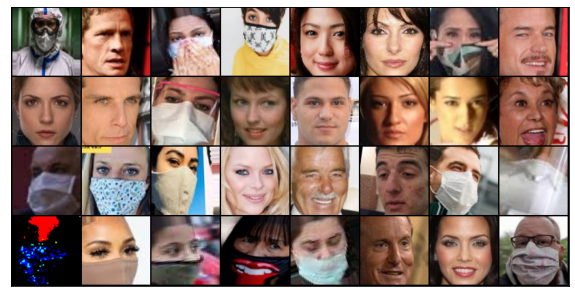

In [23]:
show_batch(train_dl)

# GPU Utility Functions and Classes

In [24]:
torch.cuda.is_available()

True

In [25]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [26]:
device = get_default_device()

In [27]:
img, label = train_ds[0]

In [28]:
img.device

device(type='cpu')

In [29]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

In [30]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# Model and Training Utilities

In [31]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
      #Calculate loss for a batch of training data
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [32]:
@torch.no_grad()
def evaluate(model, val_loader):
    #Evaluates the model's performance on the validation set
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Model

In [33]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [34]:
model = to_device(ResNet9(3, len(train_ds.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [35]:
torch.cuda.empty_cache()
for batch in train_dl:
    images, labels = batch
    print('images.shape', images.shape)
    print('images.device', images.device)
    preds = model(images)
    print('preds.shape', preds.shape)
    break

images.shape torch.Size([32, 3, 100, 100])
images.device cuda:0
preds.shape torch.Size([32, 2])


# Training

In [36]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.48076921701431274, 'val_loss': 0.6962432861328125}]

In [37]:
history += fit(5, 0.0001, model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.1287, val_loss: 0.0407, val_acc: 0.9844
Epoch [1], train_loss: 0.0348, val_loss: 0.0144, val_acc: 0.9940
Epoch [2], train_loss: 0.0163, val_loss: 0.0255, val_acc: 0.9880
Epoch [3], train_loss: 0.0163, val_loss: 0.0130, val_acc: 0.9940
Epoch [4], train_loss: 0.0188, val_loss: 0.0178, val_acc: 0.9916


In [38]:
history += fit(5, 0.000001, model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.0121, val_loss: 0.0146, val_acc: 0.9928
Epoch [1], train_loss: 0.0088, val_loss: 0.0145, val_acc: 0.9928
Epoch [2], train_loss: 0.0062, val_loss: 0.0115, val_acc: 0.9940
Epoch [3], train_loss: 0.0045, val_loss: 0.0095, val_acc: 0.9952
Epoch [4], train_loss: 0.0046, val_loss: 0.0090, val_acc: 0.9952


In [40]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

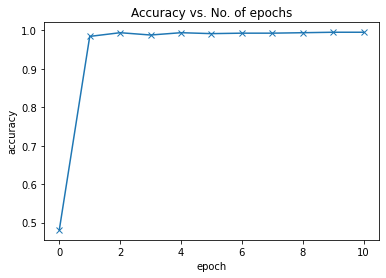

In [41]:
plot_accuracies(history)

In [42]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

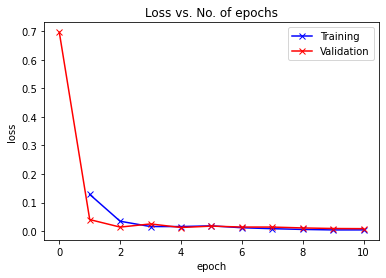

In [43]:
plot_losses(history)

In [44]:
history[-1]

{'train_loss': 0.004608545918017626,
 'val_acc': 0.995192289352417,
 'val_loss': 0.008960220031440258}

In [45]:
jovian.reset()
jovian.log_dataset(image_size=100)
jovian.log_hyperparams(batch_size=32, 
                       arch='ResNet9', 
                       epochs=[5, 5], 
                       lrs=[0.0001, 0.000001],
                       opt=['Adam', 'Adam'])
jovian.log_metrics(train_loss=history[-1]['train_loss'],
                   val_acc=history[-1]['val_acc'],
                   val_loss=history[-1]['val_loss'])

[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


# Predictions

In [46]:
def img_prediction(images):
    xb = to_device(images.unsqueeze(0), device)
    out = model(xb)
    _, preds = torch.max(out, dim=1)
    prediction = preds[0].item()
    return prediction

Label: 0
Predictions: 0


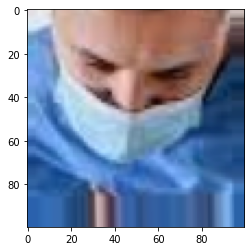

In [56]:
images, labels = test_ds[87]
print("Label:", labels)
print("Predictions:", img_prediction(images))
plt.imshow(images.permute(1,2,0));

Label: 0
Predictions: 0


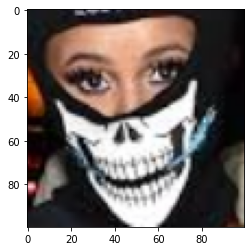

In [60]:
images, labels = test_ds[26]
print("Label:", labels)
print("Predictions:", img_prediction(images))
plt.imshow(images.permute(1,2,0));

In [61]:
torch.save(model.state_dict(), 'face-mask-detection-resnet9.pth')